# Calibração de Câmera

A calibração de câmera é um processo utilizado para determinar e corrigir possíveis distorções e imperfeições nas medições realizadas por uma câmera. Câmeras digitais e até mesmo câmeras em dispositivos móveis podem apresentar desvios em relação às medidas reais devido a fatores como variações ópticas, alinhamento incorreto de componentes ou erros no sensor da câmera.

A calibração de câmera busca estabelecer uma correspondência precisa entre as coordenadas tridimensionais do mundo real e as coordenadas bidimensionais das imagens capturadas pela câmera. 

## Introdução e Objetivo


Esta tarefa tem o objetivo de realizar a calibração de câmera. Para isso, foi necessário entender sobre: os tipos de distorções causados por uma câmera, como encontrar as propriedades intrínsecas e extrínsecas de uma câmera e aprender  como realizar o processo de *Undistort*.

Objetivo Principal da TA: Obter as matrizes e realizar a remoção da distorção provocada pela câmera.

# Imagem com distorção

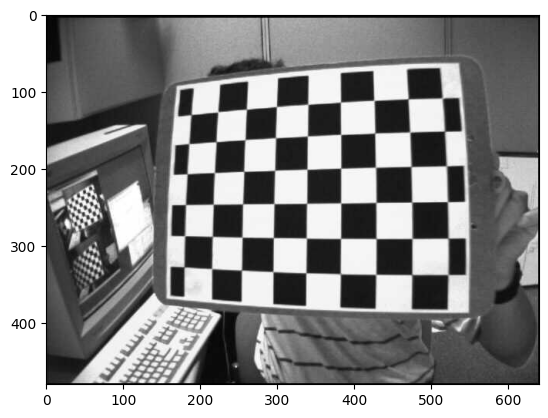

In [3]:
#import das bibliotecas
import numpy as np
import cv2 as cv
import glob
from matplotlib import pyplot as plt

# leitura e exibição da imagem
image = cv.imread("./img/left04.jpg")
plt.imshow(image) 
plt.show() 


Este é o exemplo de imagem que gostariamos de corrigir a partir da calibraçãode câmera que será feita. Através da imagem acima é possível observar a presença do efeito de *fish eye*, em que as imagens são afetadas por um aspecto distorcido e esticado, com as linhas retas tornando-se curvadas em direção às bordas da imagem e criando uma sensação de distorção. Além disso, os objetos que estão próximos à lente são ampliados e parecem mais proeminentes em relação aos outros elementos da cena. Isso cria uma sensação de proximidade e destaque.

Como eu não tinha a disposição uma câmera de baixa qualidade e um tabuleiro de xadrez ou algo do tipo, optei por utilizar as imagens disponibilizadas na documentação do Open Cv.


## Processo de Calibração de Câmera

O processo de calibração de câmera envolve a captura de imagens de um padrão conhecido, geralmente um tabuleiro de xadrez ou um objeto com características conhecidas e bem distribuídas. Essas imagens são usadas para extrair informações sobre as propriedades intrínsecas da câmera, como distorção radial, distorção tangencial, parâmetros de projeção, entre outros. A distorção radial faz com que linhas retas pareçam curvas e aumenta à medida que os pontos estão mais distantes do centro da imagem, enquanto a distorção tangencial ocorre quando a lente da câmera não está alinhada perfeitamente paralela ao plano de imagem, resultando em áreas da imagem que podem parecer mais próximas do que o esperado.

Essas informações são então utilizadas para criar um modelo matemático que descreve o comportamento da câmera e suas características específicas. Com base nesse modelo, é possível corrigir as distorções e realizar medições mais precisas nas imagens capturadas pela câmera.

Seguiremos com trechos de códigos que realizam a Calibração de Câmera (com comentários para facilitar o entendimento).

In [4]:
# definimos o tamanho do tabuleiro 
chessBM = 6
chessBN = 7
# criamos um array de posições nulas e definimos os object points
objp = np.zeros((chessBM * chessBN,3), np.float32)
objp[:,:2] = np.mgrid[0:chessBN,0:chessBM].T.reshape(-1,2)

In [5]:
# definimos o criterio de termino (quando deve-se interromper a calibragem)
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# criamos Arrays que armazenam respectivamente os object points e os image points de toda lista de imagens.
objpoints = [] # ponto 3d no mundo real
imgpoints = [] # ponto 2d no plano da imagem

In [6]:
# iteramos com a função glob sobre os arquivos do diretório /imgs com extensão .jpg
imgs = glob.glob("./img/*.jpg")

for fname in imgs:
    # lemos a imagem a partir da posição da imagem na lista
    img = cv.imread(fname)
    # convertemos para grayscale
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # encontramos os cantos do tabuleiro de xadrez
    ret, corners = cv.findChessboardCorners(gray, (chessBN,chessBM), None)
    
    # caso a calibração tenha sucesso, adicionamos informações aos vetores
    if ret == True:
        objpoints.append(objp)
        #utilizamos cv.cornerSubPix para refinar os corners encontrados
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        #cv.drawChessboardCorners(img, (7,6), corners2, ret)
        #cv.imshow('img', img)
        #cv.waitKey(500)

## Fim da Calibração

Aqui utilizaremos a biblioteca cv.calibrateCamera(). Ela recebe como parâmetros os pontos do objeto (objpoints), os pontos da imagem (imgpoints), o tamanho da imagem em escala de cinza (gray.shape[::-1]), bem como outros parâmetros opcionais que não foram fornecidos neste caso.

Para melhor explicação deste pequeno e robusto trecho de código sem que haja poluição do código com comentários, iremos definir um a um.

ret: valor de retorno da função, indicando o sucesso ou falha da calibração.

mtx: matriz da câmera (também conhecida como matriz de projeção), que descreve as propriedades intrínsecas da câmera, como foco, ponto principal e distorção.

dist: coeficientes de distorção da câmera, que corrigem as distorções radiais e tangenciais.

rvecs: vetores de rotação, que representam as rotações da câmera em relação ao sistema de coordenadas do mundo.

tvecs: vetores de "tradução", que representam as translações da câmera em relação ao sistema de coordenadas do mundo.

In [7]:
# a calibração termina aqui, onde já obtemos os image points, object points 
# ao usar a função de calibração, retorna-se a matriz da câmera, os coeficientes de distorção, vetores de rotação e tradução.
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## Processo de *Undistortion*

In [8]:
# a imagem 'left04.jpg' é lida e suas dimensões (altura e largura) são obtidas
img = cv.imread('./img/left04.jpg')
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

 A função cv.getOptimalNewCameraMatrix() é usada para calcular uma nova matriz da câmera (newcameramtx) com base na matriz da câmera original (mtx), nos coeficientes de distorção (dist) e no tamanho da imagem. O parâmetro de escala é definido como 1 e a ROI da imagem é retornada como 'roi'.

In [9]:
# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv.imwrite('resultado_left04.png', dst)

True

Nesse trecho de código, a função cv.undistort() é usada para o processo de *undistort* da imagem 'img' com base na matriz da câmera original (mtx), nos coeficientes de distorção (dist) e na nova matriz da câmera (newcameramtx). O resultado do *undistort* é armazenado em 'dst'. Em seguida, a imagem é recortada usando as coordenadas da ROI (x, y, w, h) obtidas anteriormente.


##  Comparação antes/depois da Calibração de Câmera

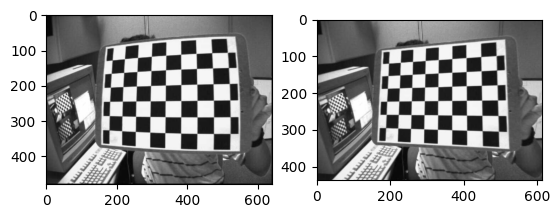

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)
ax2.imshow(dst)

Após a calibração da câmera, as distorções foram corrigidas por meio da aplicação de parâmetros de correção, como a matriz da câmera e os coeficientes de distorção. A imagem pós calibração apresenta linhas retas verdadeiramente retas, objetos com formas corretas e as bordas da imagem estão sem distorções visíveis, distorções estas, causadas por fatores como a distorção radial e tangencial da lente da câmera. A correção destas distorções resulta em uma imagem mais precisa e fiel à realidade, em que as medidas e proporções dos objetos são mais confiáveis. 